
# Export Promptflow Outputs - Classification Accuracy

This script is used for downloading all the run info needed and merge them together in local environments.


## Prerequisite
Make sure all required libraries are installed.Use command below to install azureml.core:

    pip install azureml-core

In [58]:
import csv
import json
import logging
import requests
from pathlib import Path
from azureml.core import Workspace, Experiment, Run
from azureml.core.authentication import InteractiveLoginAuthentication

import warnings
warnings.filterwarnings('ignore')

## Get workspace
Get gonnections to workspace with personal token.

Update `tenant_id`, `subscription_id`, `resource_group`, and `workspace_name` below.

In [2]:
# Get a logger which allows us to log events that occur when running the program.
logger = logging.getLogger("myLogger")
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter("%(asctime)s %(message)s")
ch = logging.StreamHandler()
ch.setFormatter(formatter)
ch.setLevel(logging.DEBUG)
if not logger.handlers:
    logger.addHandler(ch)

# Get the workspace associated with your personal token and get the relavant datastore.
tenant_id = ""
subscription_id = ""
resource_group = ""
workspace_name = ""

interactive_auth = InteractiveLoginAuthentication(tenant_id=tenant_id)
ws = Workspace.get(workspace_name, subscription_id=subscription_id, resource_group=resource_group, auth=interactive_auth)
region = ws.location
default_datastore = ws.get_default_datastore()

## Define utils
Define functions for downloading and loading run info.

In [89]:
# Get run infor for the given run_id
def get_run_info(run_id):
    logger.info(f"Getting Run Info for Run: {run_id}")
    run = ws.get_run(run_id=run_id)
    display_name = run.display_name
    input_run_id = run.properties.get('azureml.promptflow.input_run_id')
    return display_name, input_run_id

# Get the output asset id for the given run_id and asset_name
def get_output_asset_id(run_id, asset_name):
    logger.info(f"Getting Output Asset Id for Run {run_id}")
    if region == "centraluseuap":
        url = f"https://int.api.azureml-test.ms/history/v1.0/subscriptions/{subscription_id}/resourceGroups/{resource_group}/providers/Microsoft.MachineLearningServices/workspaces/{workspace_name}/rundata"
    else:
        url = f"https://ml.azure.com/api/{region}/history/v1.0/subscriptions/{subscription_id}/resourceGroups/{resource_group}/providers/Microsoft.MachineLearningServices/workspaces/{workspace_name}/rundata"
    payload = {
        "runId": run_id,
        "selectRunMetadata": True
    }
    response = requests.post(url, json=payload, headers=ws._auth.get_authentication_header())
    if response.status_code != 200:
        raise Exception(f"Failed to get output asset id for run {run_id} because RunHistory API returned status code {response.status_code}. Response: {response.text}")
    output_asset_id = response.json()["runMetadata"]["outputs"][asset_name]["assetId"]
    return output_asset_id

# Get the asset path for the given asset_id
def get_asset_path(asset_id):
    logger.info(f"Getting Asset Path for Asset Id {asset_id}")
    if region == "centraluseuap":
        url = f"https://int.api.azureml-test.ms/data/v1.0/subscriptions/{subscription_id}/resourceGroups/{resource_group}/providers/Microsoft.MachineLearningServices/workspaces/{workspace_name}/dataversion/getByAssetId"
    else:
        url = f"https://ml.azure.com/api/{region}/data/v1.0/subscriptions/{subscription_id}/resourceGroups/{resource_group}/providers/Microsoft.MachineLearningServices/workspaces/{workspace_name}/dataversion/getByAssetId"
    payload = {
        "value": asset_id,
    }
    response = requests.post(url, json=payload, headers=ws._auth.get_authentication_header())
    if response.status_code != 200:
        raise Exception(f"Failed to get asset path for asset id {asset_id} because Data API returned status code {response.status_code}. Response: {response.text}")
    data_uri = response.json()["dataVersion"]["dataUri"]
    relative_path = data_uri.split("/paths/")[-1]
    return relative_path

# Get the flow artifact relative path for the given run_id
def get_flow_artifact_relative_path(run_id):
    logger.info(f"Getting Flow Artifact Relative Path for Run {run_id}")
    try:
        flow_artifact_asset_id = get_output_asset_id(run_id, "debug_info")
        relative_path = get_asset_path(flow_artifact_asset_id)
        relative_path += "flow_artifacts/"
        return relative_path
    except Exception as e:
        logger.warning("`debug_info` output assets is not available, maybe because the job ran on old version runtime, trying to get `flow_outputs` output asset instead.")
        output_asset_id = get_output_asset_id(run_id, "flow_outputs")
        relative_path = get_asset_path(output_asset_id)
        return relative_path.replace("flow_outputs", "flow_artifacts")

# Download flow artifacts for the given run_id
def download_flow_artifacts(run_id, blob_prefix):
    logger.info(f"Downloading Flow Artifacts for Run {run_id}")
    target_dir = f"./downloads/{run_id}"
    default_datastore.download(target_dir, prefix=blob_prefix, overwrite=True)
    return target_dir

# Load flow artifacts of the run from the given local_dir
def load_flow_artifacts(local_dir, run_display_name):
    logger.info(f"Loading Flow Artifacts of {run_display_name} from {local_dir}")
    flow_artifacts = {}
    p = Path(local_dir)
    for file_path in p.glob("**/*.jsonl"):
        with open(file_path) as fp:
            for line in fp:
                line_record = json.loads(line)
                line_number = line_record.get("line_number")
                run_info = line_record.get("run_info") or {}
                status = run_info.get("status")
                outputs = run_info.get("output") or {}
                inputs = run_info.get("inputs") or {}
                model = 'NA'
                try:
                    model = run_info.get("api_calls")[0]['children'][0]['inputs']['deployment_name'] or {}
                except Exception as e:
                    pass
                start_time = pd.to_datetime(run_info.get('start_time'))
                end_time = pd.to_datetime(run_info.get('end_time'))
                modified_inputs = {f"inputs.{k}": v for k, v in inputs.items()}
                record = {
                    "Line number": line_number,
                    "Model": model,
                    "Run": run_display_name + ' - ' + model,
                    "Status": status,
                    "Execution Time": (end_time - start_time).total_seconds(),
                    **modified_inputs,
                    **outputs
                }
                flow_artifacts[line_number] = record
    return flow_artifacts


# Get required info for the given run_id
def get_required_info(run_id):
    logger.info(f"Processing Run: {run_id}")
    display_name, input_run_id = get_run_info(run_id)
    flow_artifact_relative_path = get_flow_artifact_relative_path(run_id)

    target_dir = download_flow_artifacts(run_id, flow_artifact_relative_path)
    flow_artifacts = load_flow_artifacts(target_dir, display_name)
    return {
        "run_id": run_id,
        "display_name": display_name,
        "input_run_id": input_run_id,
        "flow_artifacts": flow_artifacts
    }

# Update downstream flow artifacts with the given display_name
def update_downstread_flow_artifacts(flow_artifacts, display_name):
    updated_flow_artifacts = {}
    for line_number, line_record in flow_artifacts.items():
        updated_line_record = {}
        for k, v in line_record.items():
            if k == "Run" or k == "Status" or k == "Line number":
                continue
            else:
                updated_line_record[f"{k}({display_name})"] = v
        updated_flow_artifacts[line_number] = updated_line_record
    return updated_flow_artifacts

# Merge flow artifacts for the given run_infos, joining flow artifacts with the same line number
def merge_flow_artifacts(run_infos: list):
    run_info_dict = {run_info["run_id"]: run_info for run_info in run_infos}
    main_flow_infos = []
    for run_id, run_info in run_info_dict.items():
        if run_info["input_run_id"] is None:
            main_flow_infos.append(run_info)
        else:
            input_run_id = run_info["input_run_id"]
            if input_run_id in run_info_dict:
                input_run_info = run_info_dict[input_run_id]
                updated_flow_artifacts = update_downstread_flow_artifacts(run_info["flow_artifacts"], run_info["display_name"])
                for line_number, updated_flow_artifact in updated_flow_artifacts.items():
                    if line_number in input_run_info["flow_artifacts"]:
                        input_run_info["flow_artifacts"][line_number].update(updated_flow_artifact)
            else:
                # Input Run is not included, treat this run as main flow
                main_flow_infos.append(run_info)
    
    merge_result = []
    for main_flow_info in main_flow_infos:
        merge_result += list(main_flow_info["flow_artifacts"].values())
    merge_result = sorted(merge_result, key=lambda x: f"{x['Line number']}{x['Run']}")
    return merge_result

# Convert the given jsonl file to csv file
def jsonl_to_csv(jsonl_path, csv_path):
    max_keys = []
    with open(jsonl_path, "r") as jsonl_file:
        for line in jsonl_file:
            row = json.loads(line)
            if len(row.keys()) > len(max_keys):
                max_keys = list(row.keys())

    with open(jsonl_path, "r") as jsonl_file:
        with open(csv_path, "w", newline="") as csv_file:
            writer = csv.writer(csv_file)
            writer.writerow(max_keys)
            for line in jsonl_file:
                row = json.loads(line)
                csv_row = [row.get(key) for key in max_keys]
                writer.writerow(csv_row)

## Download runs
Download jsonl of the runs, merge them and save to local jsonl_path and csv_path.

In [90]:
exp = Experiment(ws, '<YOUR-RUN-NAME>')
runs = exp.get_runs()
run_ids = []

for r in runs:
    run_ids.append(r.id)

experiment_runs = [x for x in run_ids if 'evaluate' not in x]
evaluation_runs = [x for x in run_ids if 'evaluate' in x]

In [ ]:
# Download the flow artifacts from the run_ids and merge them into a single file.
deduped_run_ids = list(set(experiment_runs))
run_infos = [get_required_info(run_id) for run_id in deduped_run_ids]
merged_result = merge_flow_artifacts(run_infos)

# Save the merged result as jsonl and csv.
jsonl_path = "./merged_exp_result.jsonl"
csv_path = "./merged_exp_result.csv"
with open(jsonl_path, "w") as fp:
    for record in merged_result:
        fp.write(json.dumps(record))
        fp.write("\n")
logger.info(f"Saved merged result as jsonl to {jsonl_path}")
jsonl_to_csv(jsonl_path, csv_path)
logger.info(f"Saved merged result as csv to {csv_path}")

In [ ]:
# Download the flow artifacts from the run_ids and merge them into a single file.
deduped_run_ids = list(set(evaluation_runs))
run_infos = [get_required_info(run_id) for run_id in deduped_run_ids]
merged_result = merge_flow_artifacts(run_infos)

# Save the merged result as jsonl and csv.
jsonl_path = "./merged_eval_result.jsonl"
csv_path = "./merged_eval_result.csv"
with open(jsonl_path, "w") as fp:
    for record in merged_result:
        fp.write(json.dumps(record))
        fp.write("\n")
logger.info(f"Saved merged result as jsonl to {jsonl_path}")
jsonl_to_csv(jsonl_path, csv_path)
logger.info(f"Saved merged result as csv to {csv_path}")

## Visualize data
Load local csv file and visualize it as pandas dataframe. Make sure you have installed pandas:

    pip install pandas

In [115]:
# Load the merged result as pandas dataframe and sort it by line number.
import pandas as pd
import re
pattern = r'variant_\d+-\d+'
data = pd.read_csv('merged_exp_result.csv', dtype={'Line number': 'int64'})
df = pd.DataFrame(data)
df['Variant'] = [re.search(pattern, x).group(0) for x in df['Run']]

eval_data = pd.read_csv('merged_eval_result.csv', dtype={'Line number': 'int64'})
eval_df = pd.DataFrame(eval_data)
eval_df.sort_values(by='Line number', ascending=True)
eval_df['Variant'] = [re.search(pattern, x).group(0) for x in eval_df['Run']]
eval_df.iloc[0]['Variant']

result = pd.merge(df, eval_df[['Variant', 'Line number', 'inputs.groundtruth', 'inputs.prediction', 'grade']], 
                  left_on=['Variant', 'Line number'], 
                  right_on=['Variant', 'Line number'],
                  how='left')
result

,Line number,Model,Run,Status,Execution Time,inputs.user_query,inputs.line_number,category,Variant,inputs.groundtruth,inputs.prediction,grade
0,0,gpt-35-turbo,RequestClassification-variant_0-202404011734 -...,Completed,0.276912,How can I reset my password?,0,IT,variant_0-202404011734,IT,IT,Correct
1,0,gpt-4-32k,RequestClassification-variant_0-202404011756 -...,Completed,0.422412,How can I reset my password?,0,IT,variant_0-202404011756,IT,IT,Correct
2,0,gpt-4-32k,RequestClassification-variant_0-202404020102 -...,Completed,0.444012,How can I reset my password?,0,IT,variant_0-202404020102,IT,IT,Correct
3,0,gpt-4-32k,RequestClassification-variant_0-202404020104 -...,Completed,0.757867,How can I reset my password?,0,IT,variant_0-202404020104,IT,IT,Correct
4,0,gpt-35-turbo,RequestClassification-variant_0-202404020110 -...,Completed,0.284618,How can I reset my password?,0,IT,variant_0-202404020110,IT,IT,Correct
...,...,...,...,...,...,...,...,...,...,...,...,...
120,9,gpt-35-turbo,RequestClassification-variant_0-202404011734 -...,Completed,0.141911,What are some good practices for a healthy wor...,9,GENERAL,variant_0-202404011734,GENERAL,GENERAL,Correct
121,9,gpt-4-32k,RequestClassification-variant_0-202404011756 -...,Completed,0.334789,What are some good practices for a healthy wor...,9,GENERAL,variant_0-202404011756,GENERAL,GENERAL,Correct
122,9,gpt-4-32k,RequestClassification-variant_0-202404020102 -...,Completed,0.429366,What are some good practices for a healthy wor...,9,GENERAL,variant_0-202404020102,GENERAL,GENERAL,Correct
123,9,gpt-4-32k,RequestClassification-variant_0-202404020104 -...,Completed,2.981008,What are some good practices for a healthy wor...,9,GENERAL,variant_0-202404020104,GENERAL,GENERAL,Correct


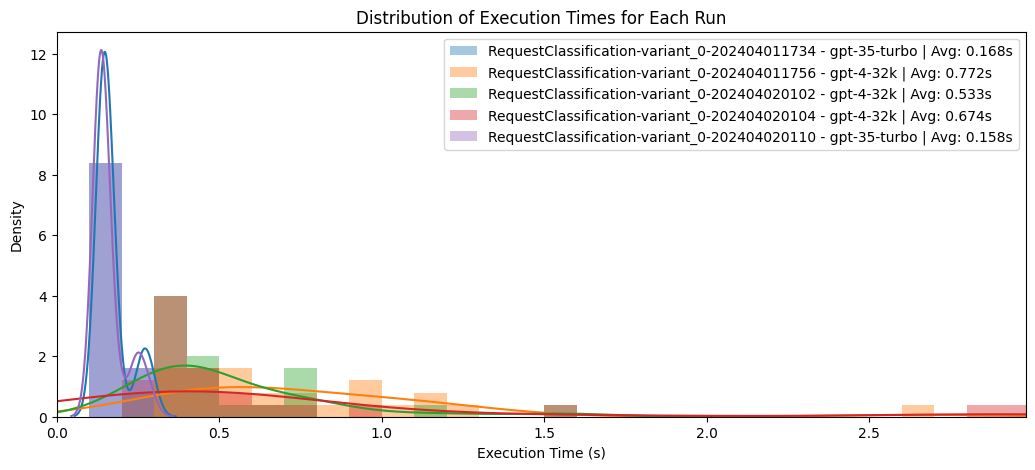

In [116]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming your dataframe is named df

# Find the global min and max across all groups to ensure consistent bins
global_min = 0
global_max = result['Execution Time'].max()

# Define the number of bins or a bin width
bin_size = 0.1  # Change this to your desired bin width
bins = np.arange(global_min, global_max + bin_size, bin_size)

# Group by 'Run' and collect all execution times in lists
grouped = result.groupby('Run')['Execution Time'].apply(list).reset_index()

# Calculate aspect ratio for x: 2.5, y: 1
y_size = 5
x_size = 2.5 * y_size

# Set up the matplotlib figure with the aspect ratio
plt.figure(figsize=(x_size, y_size))

# Plot the distribution for each run using seaborn with specified bin edges
for _, row in grouped.iterrows():
    sns.distplot(row['Execution Time'], bins=bins, kde=True,
                 label=row['Run'] + ' | Avg: ' + str(round(np.mean(row['Execution Time']), 3))+'s')

# Set the x-axis limits to the global min and max
plt.xlim(global_min, global_max)

plt.title('Distribution of Execution Times for Each Run')
plt.xlabel('Execution Time (s)')
plt.ylabel('Density')
plt.legend()
plt.show()


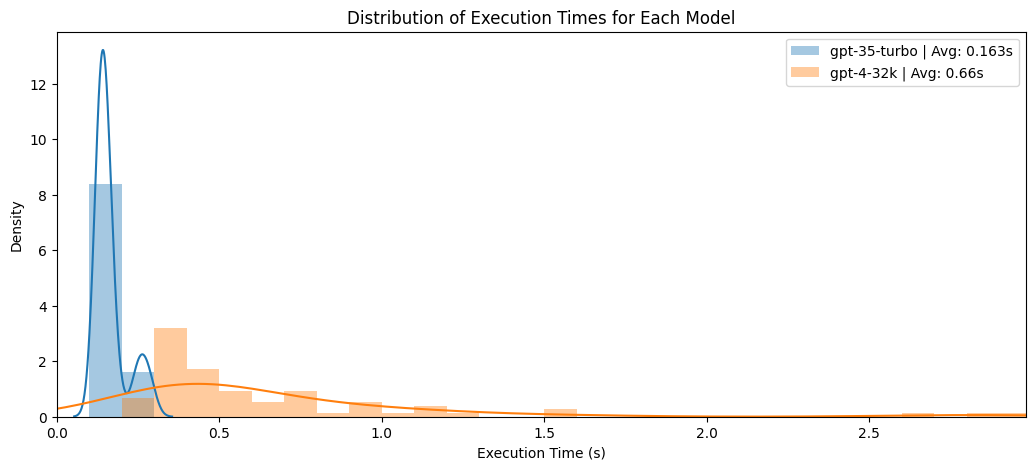

In [117]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming your dataframe is named df

# Find the global min and max across all groups to ensure consistent bins
global_min = 0
global_max = result['Execution Time'].max()

# Define the number of bins or a bin width
bin_size = 0.1  # Change this to your desired bin width
bins = np.arange(global_min, global_max + bin_size, bin_size)

# Group by 'Run' and collect all execution times in lists
grouped = result.groupby('Model')['Execution Time'].apply(list).reset_index()

# Calculate aspect ratio for x: 2.5, y: 1
y_size = 5
x_size = 2.5 * y_size

# Set up the matplotlib figure with the aspect ratio
plt.figure(figsize=(x_size, y_size))

# Plot the distribution for each run using seaborn with specified bin edges
for _, row in grouped.iterrows():
    sns.distplot(row['Execution Time'], bins=bins, kde=True,
                 label=row['Model'] + ' | Avg: ' + str(round(np.mean(row['Execution Time']), 3))+'s')

# Set the x-axis limits to the global min and max
plt.xlim(global_min, global_max)

plt.title('Distribution of Execution Times for Each Model')
plt.xlabel('Execution Time (s)')
plt.ylabel('Density')
plt.legend()
plt.show()


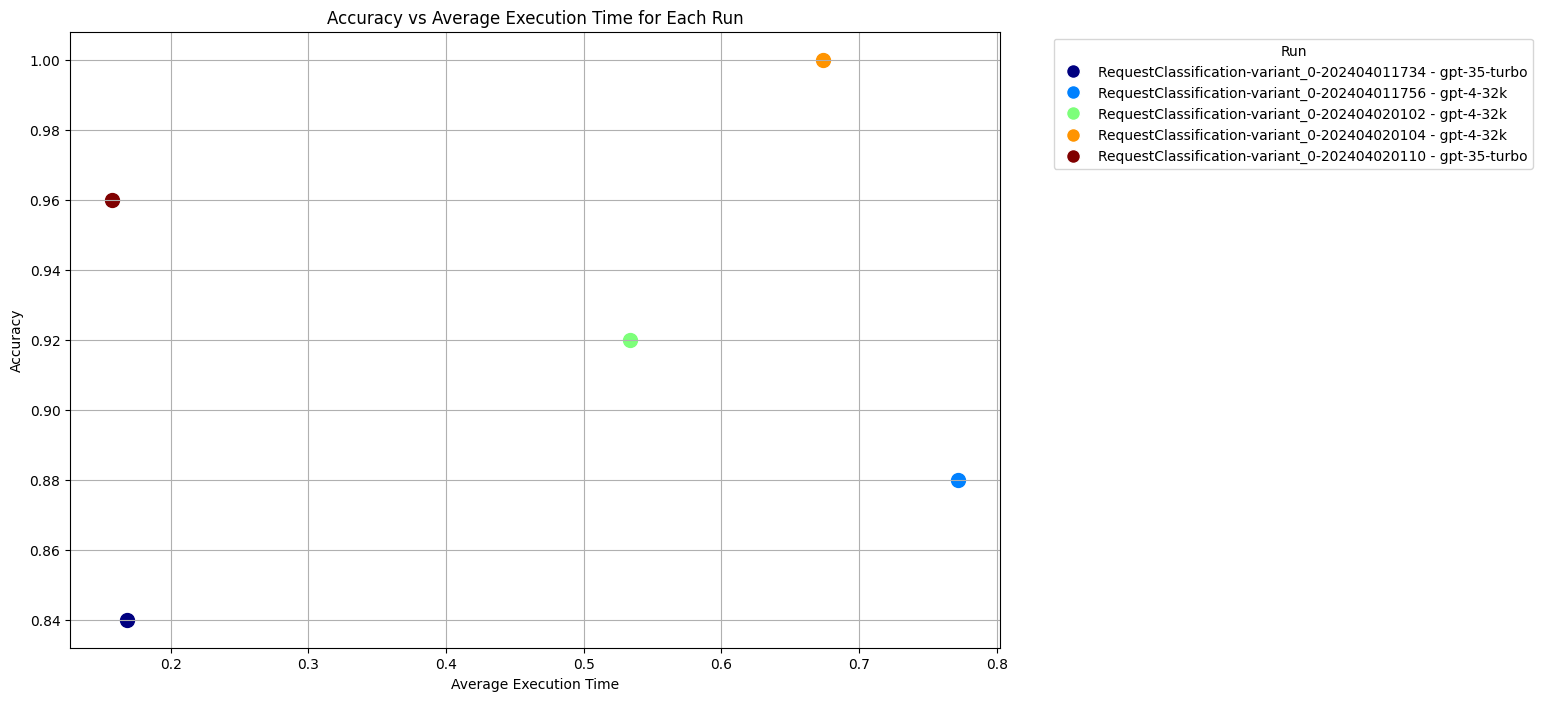

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming your dataframe is named df

# Calculate accuracy for each Run
accuracy_per_run = result.groupby('Run')['grade'].apply(lambda x: (x == 'Correct').sum() / len(x))

# Calculate average execution time for each Run
average_execution_time_per_run = df.groupby('Run')['Execution Time'].mean()

# Get the Model for each Run (assuming the Model is the same for all entries of a Run)
model_per_run = result.groupby('Run')['Model'].first()

# Create a new DataFrame
run_metrics = pd.DataFrame({
    'Accuracy': accuracy_per_run,
    'Average Execution Time': average_execution_time_per_run,
    'Model': model_per_run
}).reset_index()

# Generate a color map based on unique 'Run' values
unique_runs = run_metrics['Run'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(unique_runs)))
run_to_color = dict(zip(unique_runs, colors))

# Plot accuracy vs average execution time with colors and labels
plt.figure(figsize=(12, 8))

for _, row in run_metrics.iterrows():
    plt.scatter(row['Average Execution Time'], row['Accuracy'], color=run_to_color[row['Run']], label=row['Run'], s=100)
    # plt.text(row['Average Execution Time'], row['Accuracy'], row['Model'], fontsize=9)

# Create a legend for the colors
handles = [plt.Line2D([0], [0], marker='o', color='w', label=run,
                      markerfacecolor=run_to_color[run], markersize=10) for run in unique_runs]
plt.legend(handles=handles, title='Run', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adding titles and labels
plt.title('Accuracy vs Average Execution Time for Each Run')
plt.xlabel('Average Execution Time')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
